# Preliminary Analysis

### Basic loading and type definitions

In [490]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from scipy.stats import pearsonr
from scipy import stats

In [491]:
import warnings
warnings.filterwarnings('ignore')

In [492]:
df = pd.read_excel('../Taller1/datos.xlsx')

In [493]:
df['pais']  = df['Pais'].astype('category')
df = df.drop('Pais', axis = 1)

In [494]:
df['year'] = pd.to_datetime(df['year'], format = '%Y').dt.to_period('Y')
df.set_index(['year'], inplace= True)

In [495]:
df.columns

Index(['Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais'], dtype='object')

### 2. Change vars to logs

In [496]:
for i in ['Produccion ', 'Reservas', 'PIB', 'Oil Prices']:
    df[f'log_{i.lower().strip()}'] = df[i].apply(np.log)

In [497]:
df.rename({'log_oil prices': 'log_oil_prices'}, inplace = True, axis = 1)

In [498]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 672 entries, 1998 to 2021
Freq: A-DEC
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Produccion      672 non-null    float64 
 1   Reservas        672 non-null    float64 
 2   PIB             672 non-null    float64 
 3   Oil Prices      672 non-null    float64 
 4   pais            672 non-null    category
 5   log_produccion  672 non-null    float64 
 6   log_reservas    672 non-null    float64 
 7   log_pib         672 non-null    float64 
 8   log_oil_prices  672 non-null    float64 
dtypes: category(1), float64(8)
memory usage: 49.2 KB


### 3. Correlations

In [499]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.7, 0.1), xycoords=ax.transAxes)

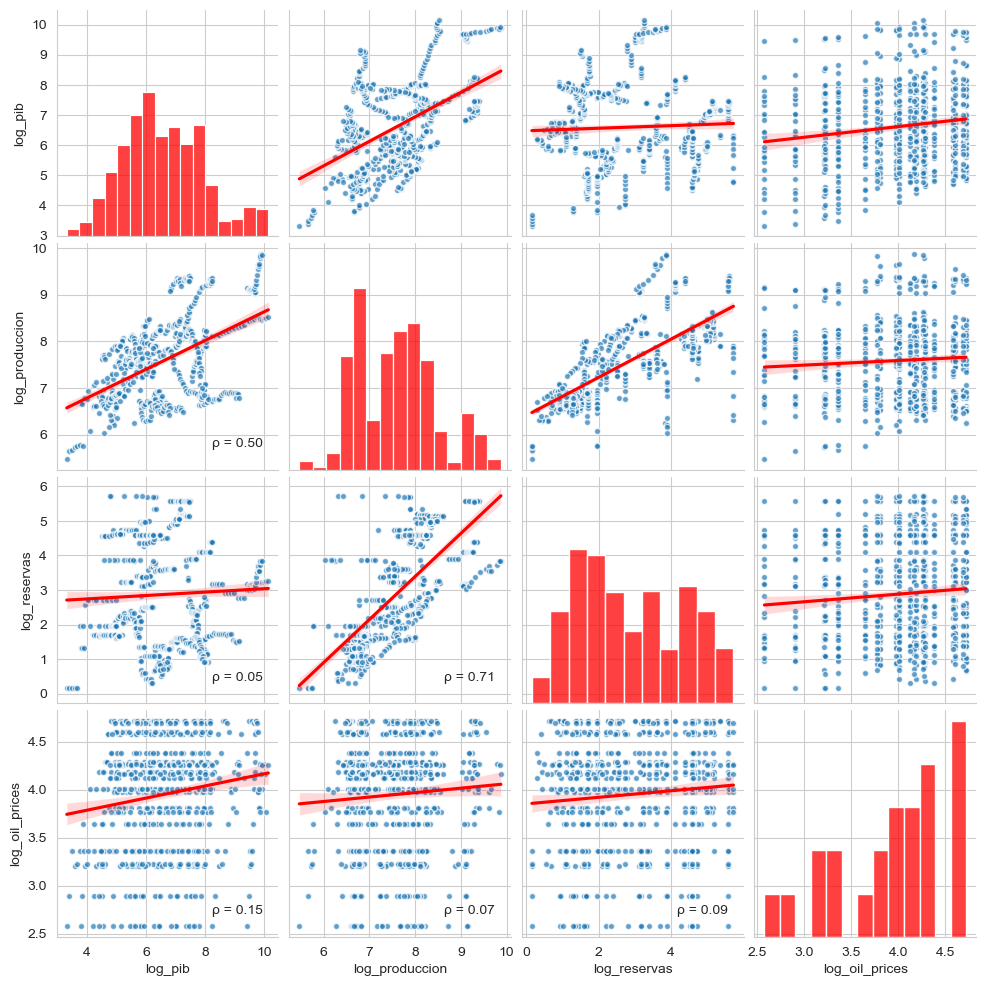

In [500]:
g = sns.pairplot(df[['log_pib', 'log_produccion', 'log_reservas', 'log_oil_prices']], kind = "reg", diag_kind='hist', diag_kws = {'color': 'red'}, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{"alpha": 0.7, "s": 20, 'edgecolors': 'white'}})
g.map_lower(corrfunc)
plt.show()

In [501]:
dpi = 300

In [502]:
g.savefig('./plots/correlogram_1,1,3.png', dpi = dpi)

###  3.a  La producción de petroleo se ve afectada fuertemente por las reservas disponibles

### 3.b Ahí están 

### 3.c Más o menos

### 4. Scatter plots

In [503]:
def plot_relations(data: pd.DataFrame, title:str, x:str, y:str):
    fig, ax =plt.subplots(2,2, figsize=(15,8), sharex = False)
    count = 1
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            sns.regplot(data = data, x = x, y = y, scatter_kws={"alpha": 0.7, "s": 20, 'edgecolors': 'white'}, line_kws = {"color": "red"}, ax = ax[i,j], order = count )
            ax[i,j].set_title(f'{title} con ajuste de orden {count}')
            count+=1
    fig.subplots_adjust(wspace=0.3, hspace = 0.3)    
    return fig

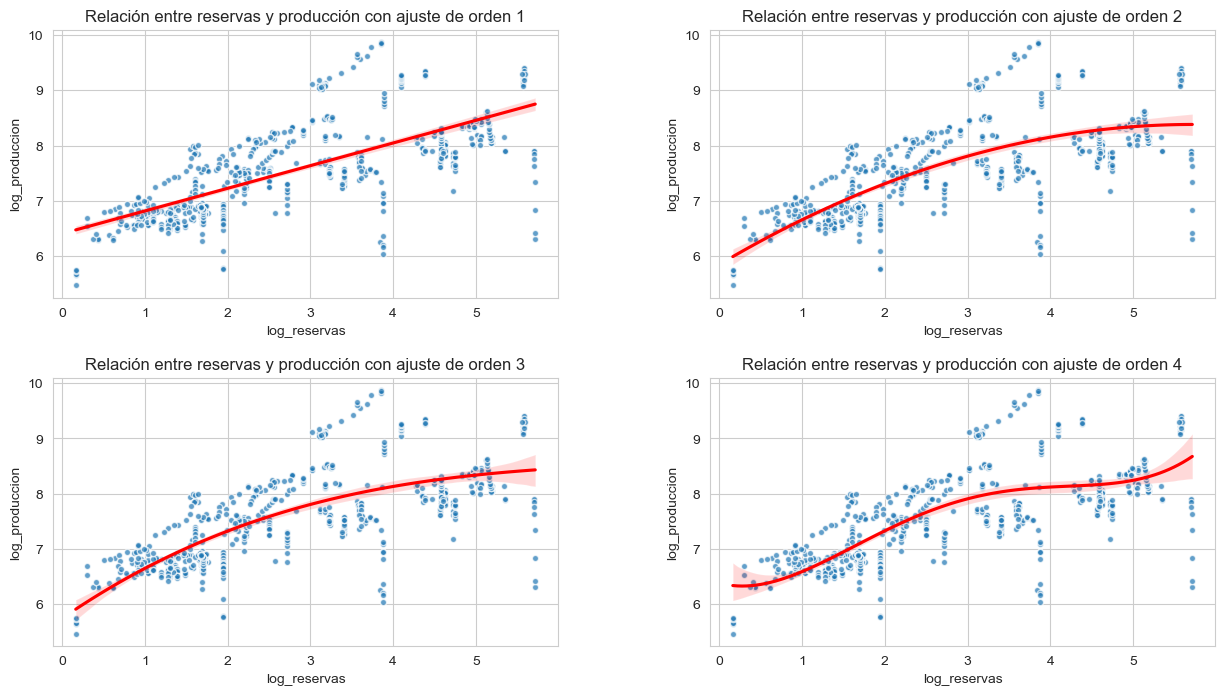

In [504]:
fig = plot_relations(df, 'Relación entre reservas y producción', 'log_reservas', 'log_produccion')

In [505]:
fig.savefig('./plots/scatter_1,1,4,1.png', dpi = dpi)

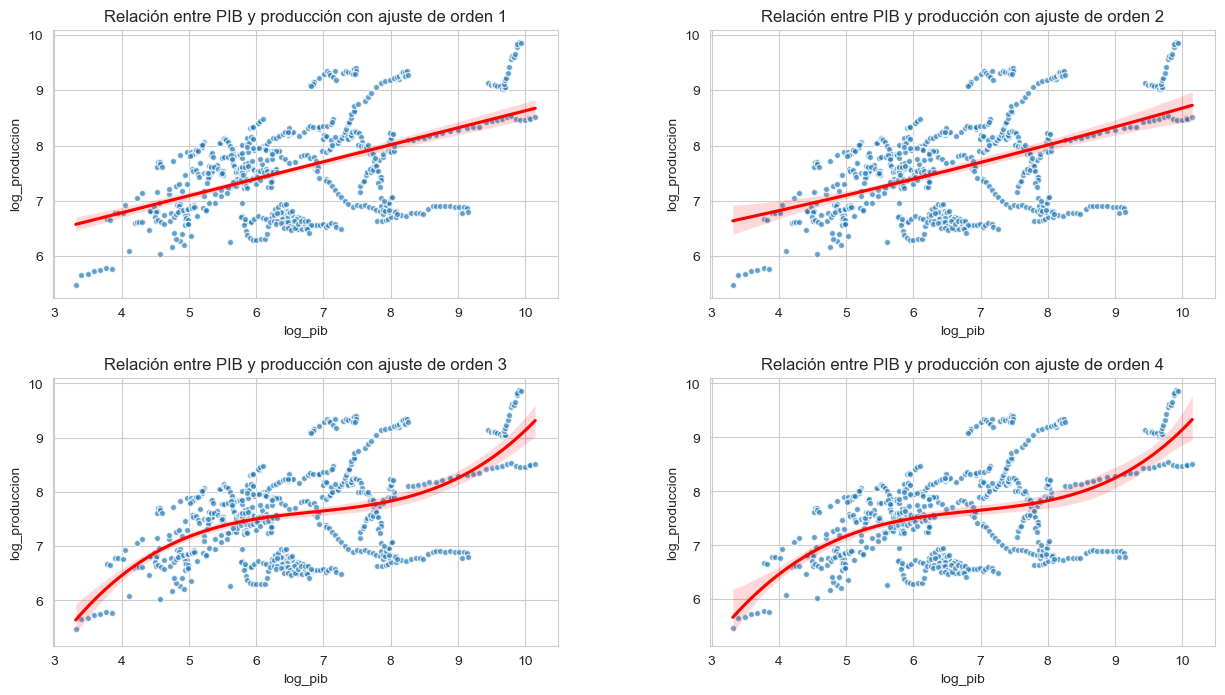

In [506]:
fig = plot_relations(df, 'Relación entre PIB y producción', 'log_pib', 'log_produccion')

In [507]:
fig.savefig('./plots/scatter_1,1,4,2.png', dpi = dpi)

### 5. Boxplot

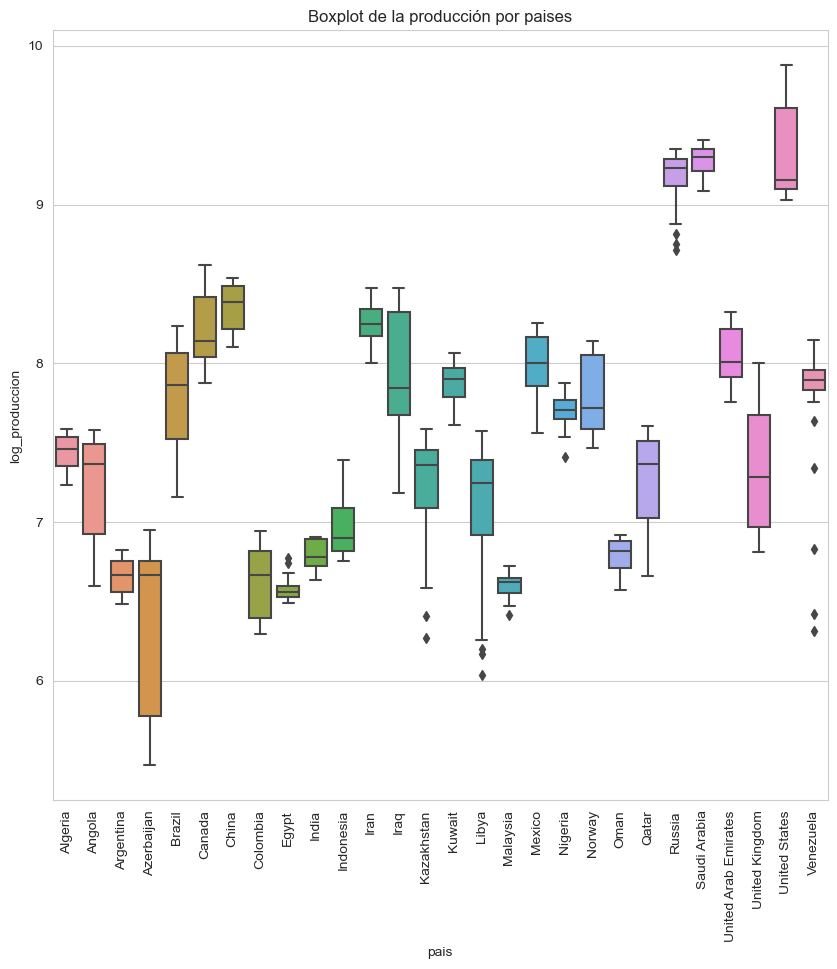

In [508]:
plt.figure(figsize = (10,10))
sns.boxplot(data = df, x = 'pais', y = 'log_produccion')
plt.xticks(rotation = 90)
plt.title('Boxplot de la producción por paises')
plt.show()

In [509]:
plt.savefig('./plots/boxplot1,1,5.png', dpi = dpi)

<Figure size 640x480 with 0 Axes>

### 6. Model Estimation
### First Model

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \varepsilon_{it}
$$

In [510]:
df['lag_reserve'] = df.groupby('pais')['log_reservas'].shift(1)

In [511]:
#Verifying we actually lost the first year's observation for all countries
df[df.index == '1998'].head()

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_reservas,log_pib,log_oil_prices,lag_reserve
year,,,,,,,,,,
1998,1402.410959,9.2000,259.29310,13.126219,Algeria,7.245948,2.219203,5.557959,2.574612,NaN
1998,734.582192,5.4120,66.92613,13.126219,Angola,6.599302,1.688619,4.203589,2.574612,NaN
1998,916.684932,2.5882,627.23620,13.126219,Argentina,6.820764,0.950963,6.441323,2.574612,NaN
1998,236.773973,1.1780,27.56175,13.126219,Azerbaijan,5.467106,0.163818,3.316429,2.574612,NaN
1998,1282.627397,4.8000,1890.76100,13.126219,Brazil,7.156666,1.568616,7.544735,2.574612,NaN


In [512]:
df['lag_resq'] = np.square(df['lag_reserve'])

In [513]:
df.columns

Index(['Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais',
       'log_produccion', 'log_reservas', 'log_pib', 'log_oil_prices',
       'lag_reserve', 'lag_resq'],
      dtype='object')

In [514]:
df[df.pais == 'Colombia']

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_reservas,log_pib,log_oil_prices,lag_reserve,lag_resq
year,,,,,,,,,,,
1998,745.938356,2.800000,342.5699,13.126219,Colombia,6.614643,1.029619,5.836476,2.574612,NaN,NaN
1999,830.424658,2.577200,328.1682,18.108219,Colombia,6.721937,0.946704,5.793526,2.896366,1.029619,1.060116
2000,704.115998,2.577200,338.4936,28.845275,Colombia,6.556943,0.946704,5.824505,3.361946,0.946704,0.896248
2001,636.824153,1.972000,344.1732,24.713763,Colombia,6.456494,0.679048,5.841145,3.207360,0.946704,0.896248
2002,588.276088,1.750000,352.7915,25.115096,Colombia,6.377196,0.559616,5.865877,3.223469,0.679048,0.461107
2003,554.676295,1.842290,366.6147,28.779103,Colombia,6.318385,0.611009,5.904311,3.359650,0.559616,0.313170
2004,541.956257,1.842290,386.1662,38.233580,Colombia,6.295185,0.611009,5.956268,3.643714,0.611009,0.373332
2005,540.686564,1.542000,403.3392,54.683848,Colombia,6.292840,0.433080,5.999778,4.001568,0.611009,0.373332
2006,548.351553,1.542000,430.4310,65.604743,Colombia,6.306917,0.433080,6.064787,4.183648,0.433080,0.187559


In [27]:
import statsmodels.api as sm

In [28]:
X1 = sm.add_constant(df[['lag_reserve', 'lag_resq', 'log_pib', 'log_oil_prices']])
Y = df["log_produccion"]

model1 = sm.OLS(Y, X1, missing = 'drop').fit() 
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     466.0
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.52e-188
Time:                        06:40:17   Log-Likelihood:                -366.10
No. Observations:                 644   AIC:                             742.2
Df Residuals:                     639   BIC:                             764.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.5577      0.159     28.

### Second Model

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \sum_{j=1}^{27}\gamma_{j}g_{j} +  \varepsilon_{it}
$$

In [29]:
model2= sm.formula.ols('log_produccion ~ C(pais) + lag_reserve + lag_resq  + log_pib + log_oil_prices', data=df).fit()
print(model2.summary()) 

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     419.1
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        06:40:17   Log-Likelihood:                 192.95
No. Observations:                 644   AIC:                            -321.9
Df Residuals:                     612   BIC:                            -178.9
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Aquí iría el análisis

### 7. In sample prediction

In [30]:
predictions = np.exp(model2.predict(df[df.index == '2021']).values)
labels = df[df.index == '2021']['Produccion '].values
errors = predictions - labels

In [31]:
results = pd.DataFrame(data = {'pais': df[df.index=='2021']['pais'], 'produccion':  labels, 'pred_prod': predictions, 'residuals': errors})
results

,pais,produccion,pred_prod,residuals
year,,,,
2021,Algeria,1415.129339,1885.236710,470.107371
2021,Angola,1196.686957,1583.729017,387.042060
2021,Argentina,702.330031,771.184064,68.854032
2021,Azerbaijan,716.735073,912.253896,195.518823
2021,Brazil,3689.416939,2759.453086,-929.963854
2021,Canada,5537.451003,4273.100038,-1264.350965
2021,China,4993.069739,6070.072293,1077.002554
2021,Colombia,764.186095,873.139099,108.953005
2021,Egypt,659.821906,800.743607,140.921701


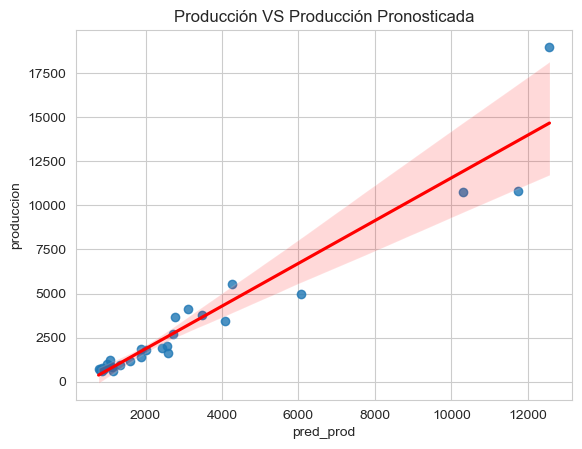

In [32]:
sns.set_style('whitegrid')
sns.regplot(x = results['pred_prod'], y = results['produccion'], line_kws = {'color': 'red'})
plt.title('Producción VS Producción Pronosticada')
plt.savefig('./plots/regplot1,1,6.png', dpi = dpi)

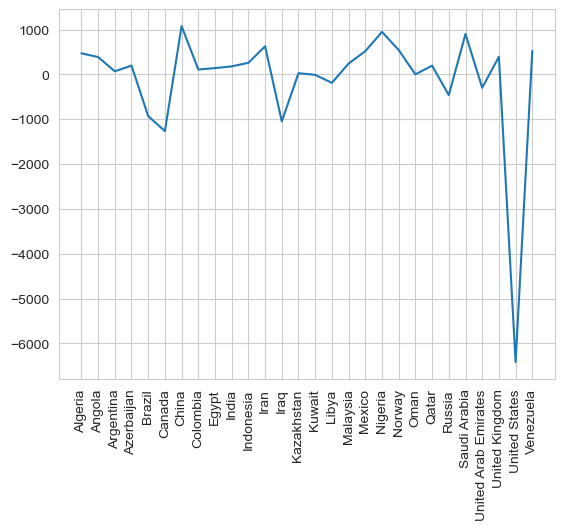

In [33]:
plt.plot( results['pais'], errors)
plt.gca().set_xticklabels(results.pais.values)
plt.xticks(rotation=90)
plt.show()

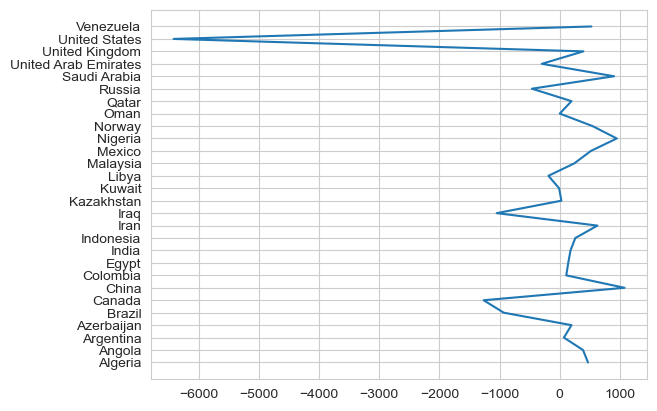

In [34]:
plt.plot(errors, results['pais'])


In [35]:
# Ufff pasó algo feo con Estados Unidos 

In [36]:
#Cuál se verá mejor?

# Intervals and Densities

In [391]:
pib = np.log(710.2)
oil = np.log(70.8)
reserve = 0.92

$$
\varepsilon_{it}\sim N(0, \sigma^2) 
$$

### 1.1 Error estimation without simulation

In [392]:
import pyarrow

In [616]:
#df.reset_index(inplace=True)
#df.to_csv('./first.csv')
#df.to_parquet('./first.parquet')

In [617]:
df = pd.read_parquet('./first.parquet')

In [618]:
df.set_index(['year'], inplace= True)

In [666]:
np.std(model2.resid)

0.17932614263406607

In [667]:
mean = 0
std =  np.std(model2.resid)

$$
margin\_of\_error = z^{*} \left(\frac{\sigma}{\sqrt{n}}\right)
$$

In [668]:
n = len(df)
n_root = np.sqrt(n)

In [669]:
z_star = stats.norm.ppf(0.975)

In [670]:
margin_of_error = z_star*(std/n_root)

In [671]:
margin_of_error

0.013558356884098502

In [650]:
df.drop(['log_reservas', 'lag_reserve', 'lag_resq'],axis = 1, inplace= True)

In [651]:
df.loc[(df.pais == 'Colombia') & (df.index == '2021'),['Reservas'] ] = reserve

In [652]:
df[df.pais =='Colombia']

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_pib,log_oil_prices
year,,,,,,,,
1998,745.938356,2.800000,342.5699,13.126219,Colombia,6.614643,5.836476,2.574612
1999,830.424658,2.577200,328.1682,18.108219,Colombia,6.721937,5.793526,2.896366
2000,704.115998,2.577200,338.4936,28.845275,Colombia,6.556943,5.824505,3.361946
2001,636.824153,1.972000,344.1732,24.713763,Colombia,6.456494,5.841145,3.207360
2002,588.276088,1.750000,352.7915,25.115096,Colombia,6.377196,5.865877,3.223469
2003,554.676295,1.842290,366.6147,28.779103,Colombia,6.318385,5.904311,3.359650
2004,541.956257,1.842290,386.1662,38.233580,Colombia,6.295185,5.956268,3.643714
2005,540.686564,1.542000,403.3392,54.683848,Colombia,6.292840,5.999778,4.001568
2006,548.351553,1.542000,430.4310,65.604743,Colombia,6.306917,6.064787,4.183648


In [653]:
df['log_reservas'] = np.log(df.Reservas)

In [654]:
df['lag_reserve'] = df.groupby('pais')['log_reservas'].shift(1)

In [655]:
df['lag_resq'] = np.square(df['lag_reserve'])

In [656]:
df[df.pais =='Colombia']

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_pib,log_oil_prices,log_reservas,lag_reserve,lag_resq
year,,,,,,,,,,,
1998,745.938356,2.800000,342.5699,13.126219,Colombia,6.614643,5.836476,2.574612,1.029619,NaN,NaN
1999,830.424658,2.577200,328.1682,18.108219,Colombia,6.721937,5.793526,2.896366,0.946704,1.029619,1.060116
2000,704.115998,2.577200,338.4936,28.845275,Colombia,6.556943,5.824505,3.361946,0.946704,0.946704,0.896248
2001,636.824153,1.972000,344.1732,24.713763,Colombia,6.456494,5.841145,3.207360,0.679048,0.946704,0.896248
2002,588.276088,1.750000,352.7915,25.115096,Colombia,6.377196,5.865877,3.223469,0.559616,0.679048,0.461107
2003,554.676295,1.842290,366.6147,28.779103,Colombia,6.318385,5.904311,3.359650,0.611009,0.559616,0.313170
2004,541.956257,1.842290,386.1662,38.233580,Colombia,6.295185,5.956268,3.643714,0.611009,0.611009,0.373332
2005,540.686564,1.542000,403.3392,54.683848,Colombia,6.292840,5.999778,4.001568,0.433080,0.611009,0.373332
2006,548.351553,1.542000,430.4310,65.604743,Colombia,6.306917,6.064787,4.183648,0.433080,0.433080,0.187559


In [657]:
std

0.17932614263406607

In [684]:
new_pred = (model2.predict(df.loc[(df.index == '2021')&(df.pais =='Colombia')]).values)
new_pred_norm = np.exp(new_pred)
new_pred_norm

array([873.13909935])

In [704]:
lower = new_pred - (2*std)
upper = new_pred + (2*std)
print(f"For the theorical normal distribution of the errors, the forecast for production is {new_pred_norm[0]},\nwith confidence intervals: {np.exp(lower)[0]} and {np.exp(upper)[0]}")

For the theorical normal distribution of the errors, the forecast for production is 873.1390993544351,
with confidence intervals: 609.9900177955197 and 1249.8104306307446


### 1.2 Error estimation with simulation

In [705]:
seed = np.random.seed(42)

In [706]:
all_errors = []
all_intervals = []
for i in [50,500,10000]:
    sampled_errors = np.random.normal(mean, std, i)
    sample_added = np.exp(sampled_errors + new_pred)
    all_errors.append(sample_added)
    density = np.percentile(sample_added, [2.5,97.5])
    all_intervals.append(density)
titles = ['50 simulaciones', '500 simulaciones', '10000 simulaciones']

In [723]:
for sims, ci in zip([50,500,10000],all_intervals):
    print(f'At {sims} simulations, we predict a value of {new_pred_norm}, and a confidence interval of {ci} ')

At 50 simulations, we predict a value of [873.13909935], and a confidence interval of [ 623.3569173  1156.35831576] 
At 500 simulations, we predict a value of [873.13909935], and a confidence interval of [ 634.20439713 1253.25394074] 
At 10000 simulations, we predict a value of [873.13909935], and a confidence interval of [ 613.2416454  1242.42794171] 


In [713]:
def plot_densities(n_plots: int, data: list, confidence_intervals: list, titles: list, prediction: float):
    fig, ax =plt.subplots(n_plots,1, figsize=(10,10), sharex = False)
    for i in range(len(data)):
        ax[i].set_title(titles[i])
        sns.histplot(data[i], ax = ax[i], stat = 'density', kde = True, bins = 100) 
        ax[i].axvline(confidence_intervals[i][0], color='r', linestyle='--', lw=2)
        ax[i].axvline(confidence_intervals[i][1], color='r', linestyle='--', lw=2)
        ax[i].axvline(prediction, color = 'g', lw = 4)
    fig.show()
    fig.tight_layout(pad=2.0)
    return fig

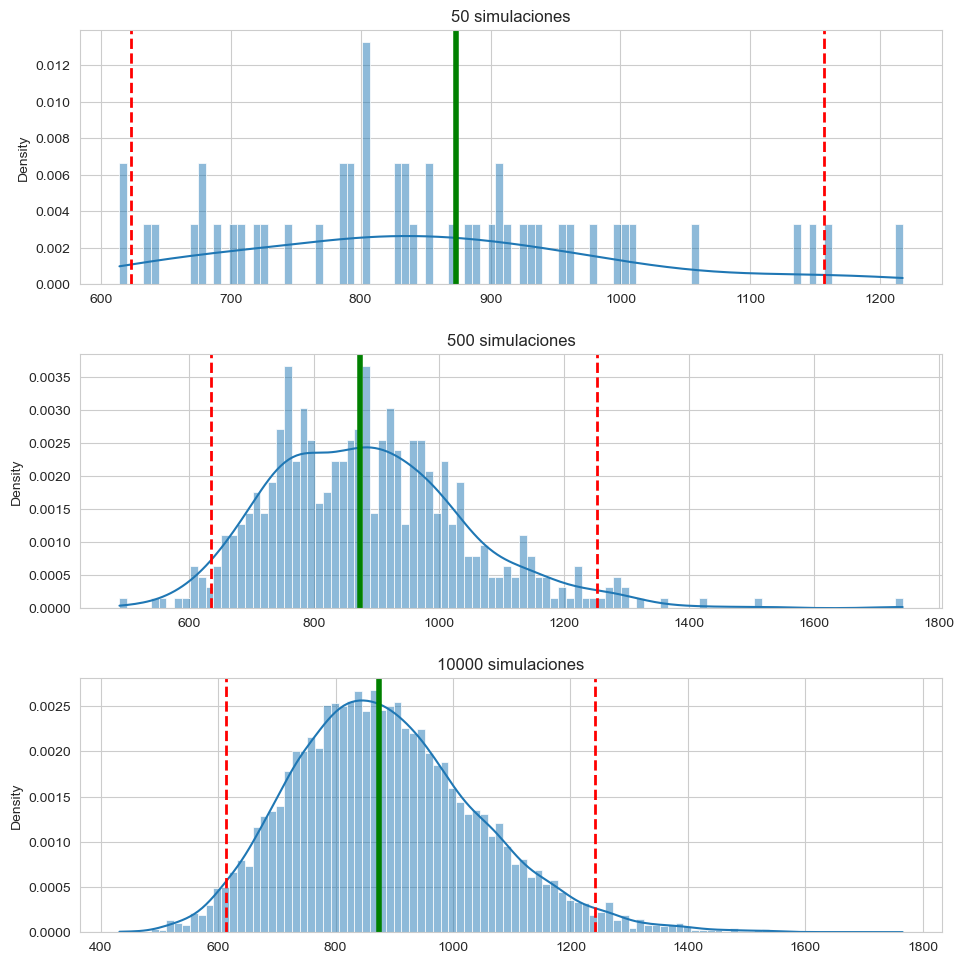

In [716]:
fig =plot_densities(3, all_errors, all_intervals, titles, new_pred_norm)
fig.savefig('./plots/density_1,2,3.png', dpi= dpi)

### 1.4 Uncertain distribution of the errors

In [724]:
import random

In [725]:
residuals = model2.resid

In [726]:
non_par_errors = random.choices(residuals, k = 10000)

In [727]:
norm_errors = np.exp(non_par_errors+ new_pred)

In [728]:
density = np.percentile(norm_errors, [2.5,97.5])
density

array([ 618.86139805, 1208.80463366])

In [730]:
print(f"The forecast for production is {new_pred_norm[0]},\nwith confidence intervals: {np.exp(lower)[0]} and {np.exp(upper)[0]}")

The forecast for production is 873.1390993544351,
with confidence intervals: 609.9900177955197 and 1249.8104306307446


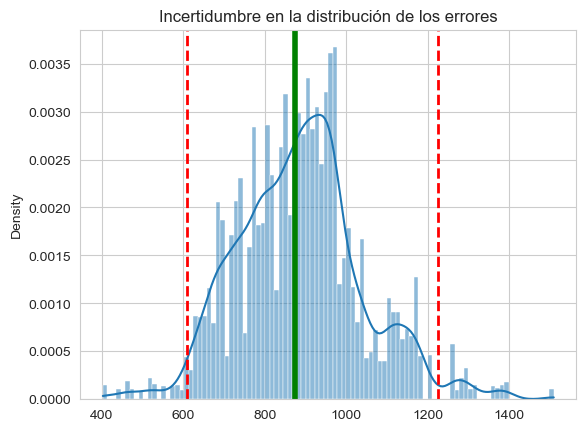

In [793]:
sns.histplot(norm_errors,  stat = 'density', kde = True, bins = 100) 
plt.axvline(density[0], color='r', linestyle='--', lw=2)
plt.axvline(density[1], color='r', linestyle='--', lw=2)
plt.axvline(new_pred_norm, color = 'g', lw = 4)
plt.title('Incertidumbre en la distribución de los errores')
plt.savefig('./plots/density_1,2,5.png', dpi = dpi)

### 1.6 Uncertainty on parameters and errors

In [739]:
coef_var = model2.cov_params()
betahat = model2.params

In [773]:
RBetas = np.random.multivariate_normal(betahat, coef_var, size=10000) #generamos una distribucón normal multinomial
non_par_errors = random.choices(residuals, k = 10000)

In [774]:
act_values = df[(df.pais =='Colombia')& (df.index == '2021')]

In [775]:
act_values

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_pib,log_oil_prices,log_reservas,lag_reserve,lag_resq
year,,,,,,,,,,,
2021,764.186095,0.92,710.2137,70.8315,Colombia,6.638811,6.565566,4.260304,-0.083382,0.672944,0.452854


In [785]:
log_prod_list = []

In [786]:
for i, j in zip(RBetas, non_par_errors):
    #intercept = i[0], col_dummy = i[7], log_oil_price = i[-1], log_gdp = i[-2], lag_res_sq = i[-3], lag_res = i[-4]
    new_estimate = i[0] + i[-1]*act_values.log_oil_prices + i[-2]*act_values.log_pib + i[-3]*act_values.lag_resq + i[-4]*act_values.lag_reserve + i[7] + j
    log_prod_list.append(new_estimate.values)    

In [787]:
norm_preds = np.exp(log_prod_list)

In [788]:
density = np.percentile(norm_preds, [2.5,97.5])
density

array([ 609.38114914, 1225.85758826])

In [790]:
print(f"The forecast for production is {new_pred_norm[0]},\nwith confidence intervals: {density[0]} and {density[1]}")

The forecast for production is 873.1390993544351,
with confidence intervals: 609.3811491374323 and 1225.857588264024


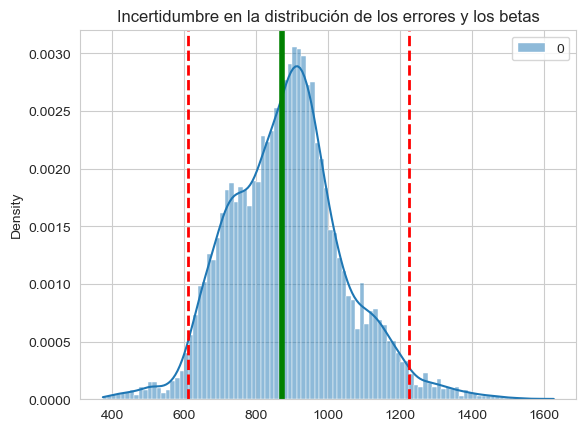

In [794]:
sns.histplot(norm_preds,  stat = 'density', kde = True, bins = 100) 
plt.axvline(density[0], color='r', linestyle='--', lw=2)
plt.axvline(density[1], color='r', linestyle='--', lw=2)
plt.axvline(new_pred_norm, color = 'g', lw = 4)
plt.title('Incertidumbre en la distribución de los errores y los betas')
plt.savefig('./plots/density_1,2,7.png', dpi = dpi)